# Single Cell Python Thresholds

Setting empirical thresholds for positivity, defining populations. Some simple statistical analyses. Visualization of tSNE and gene expression data and graphing performed in a seperate R notebook using the package Seurat.

Some simple subtractions done, presuming that variation in UMI capture is strictly a function of efficiency, and that efficiency in the canine spike-in population is equivalent to that of the human population. This should broadly be true, after subtracting doublets.



In [1]:
import pandas as pd
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
import sys
scripts = 'Scripts'
import importlib
sys.path.append(scripts)
import SingleCellPython
import numpy as np
dataFolder = 'strainedCounts/1905NSmut/'
sns.set_style("white")
sns.set_style("ticks")
import scipy
colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
segments = ['PB2_mRNA','PB1_mRNA','PA_mRNA',  'HA_mRNA','NP_mRNA','NA_mRNA','M_mRNA','NS_mRNA']
fluColors = {}
alternateFlu = ['PB2_mRNA','PB1_mRNA','PA_mRNA',  'HA_mRNA','NP_mRNA','NA_mRNA','M_mRNA','NS_vRNA']
otherfluColors = {}
for color, segment in enumerate(segments):
    fluColors[segment] = colors[color]
for color, segment in enumerate(alternateFlu):
    otherfluColors[segment] = colors[color]
typeI = ['IFNB1', 'IFNA1', 'IFNA2', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8','IFNA10', 'IFNA13', 'IFNA14', 'IFNA16', 'IFNA17' ]
typeIII = ['IL28A', 'IL28B', 'IL29']
#Threshold of positivity, likely would act similar to an FDR
quantileThresh = 0.99
from statsmodels.stats import multitest
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})
from scipy.stats import poisson

load in SoupX-processed matrices

In [2]:

data = SingleCellPython.MatrixToPandaSoupX(dataFolder + 'barcodes.tsv', dataFolder + 'genes.tsv', dataFolder + 'matrix.mtx',
                                           False, False)




Facet on number of genes expressed.

Lets remove high UMI and low UMI as potential doublets or other aberrant cells (although low RNA could be interesting, but lets leave out for this analysis)

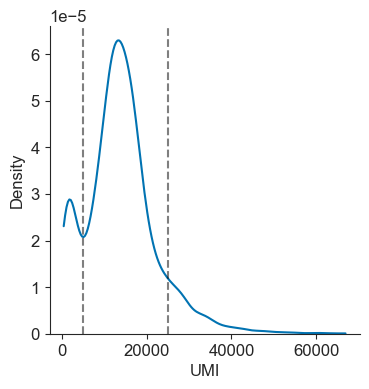

In [3]:
sums = data.groupby(['cell']).UMI.sum().reset_index()
figure, ax = plt.subplots(1,1, figsize=(4,4))
sns.kdeplot(sums.UMI, bw_method=0.2,  color=colors[0], ax=ax, cut=0)
sns.despine()
ax.axvline(x=5000,color = 'k',ls = '--', alpha =0.5)
ax.axvline(x=25000,color = 'k',ls = '--', alpha =0.5)
sums = sums.loc[(sums.UMI < 25000) & (sums.UMI > 5000)]
sums = sums.rename(columns = {'UMI':'total'})
data = data.merge(sums, on='cell')
plt.savefig('Figures/UMIcutoff_1905NSmut.pdf', format='pdf', bbox_inches = "tight")


Now based on unique genes.

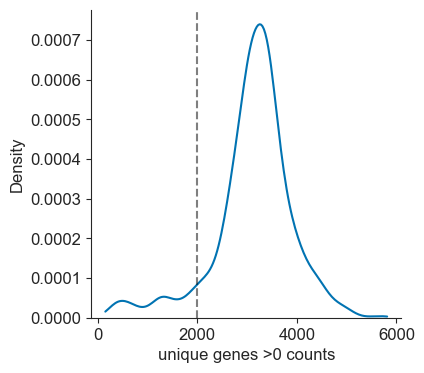

In [4]:
counts = data[data.UMI >0].groupby(['cell']).count().reset_index()
figure, ax = plt.subplots(1,1, figsize=(4,4))
sns.kdeplot(counts.UMI, bw_method=0.2,  color=colors[0], ax=ax, cut=0)
plt.xlabel('unique genes >0 counts')
sns.despine()
counts = counts.loc[(counts.UMI >= 1500)]['cell']
ax.axvline(x=2000,color = 'k',ls = '--', alpha =0.5)

data = data.merge(counts, on='cell')

plt.savefig('Figures/geneCountcutoff_1905NSmut.pdf', format='pdf', bbox_inches = "tight")

In [5]:
data['expression'] = data.UMI/data.total

genesOfInterest = segments + typeI + typeIII


typeIFrame = data[data.gene.isin(typeI)].groupby(['cell']).sum().reset_index()[['cell','expression']].rename(columns = {'expression':'typeI_expression'})

typeIIIFrame = data[data.gene.isin(typeIII)].groupby(['cell']).sum().reset_index()[['cell','expression']].rename(columns = {'expression':'typeIII_expression'})

fluFrame = data[data.gene.isin(segments)].groupby(['cell']).sum().reset_index()[['cell','expression']].rename(columns = {'expression':'influenza'})

data = data.loc[data.gene.isin(genesOfInterest),].pivot(index = 'cell', columns = 'gene', values = 'expression').fillna(0).reset_index()

data = data.merge(typeIFrame, on='cell', how='left').fillna(0)
data = data.merge(typeIIIFrame, on='cell', how='left').fillna(0)
data = data.merge(fluFrame, on='cell', how='left').fillna(0)




distribution of flu+. Set a threshold at 1% in addition to SoupX corrections

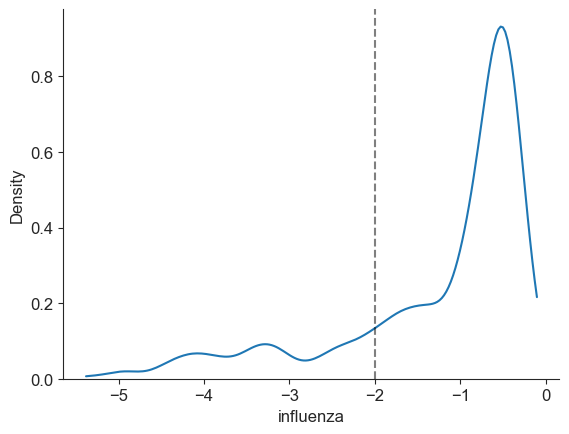

In [6]:
sns.kdeplot(np.log10(data[data.influenza > 0].influenza), cut=0, bw_method=0.15)
sns.despine()
data['influenza_positive'] = data.influenza >= 0.01
plt.axvline(x=np.log10(0.01),color = 'k',ls = '--', alpha =0.5)
plt.savefig('Figures/flucutoff_1905NSmut.pdf', format='pdf', bbox_inches = "tight")


Similar for interferons

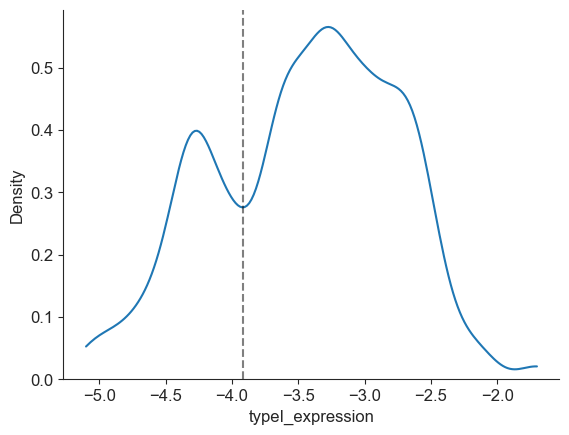

In [7]:
sns.kdeplot(np.log10(data[data.typeI_expression > 0].typeI_expression), cut=0, bw_method=0.2)
sns.despine()
plt.axvline(x=np.log10(0.00012),color = 'k',ls = '--', alpha =0.5)
data['type_I_IFN_positive'] = data.typeI_expression >= 0.00012
plt.savefig('Figures/typeIcutoff_1905NSmut.pdf', format='pdf', bbox_inches = "tight")


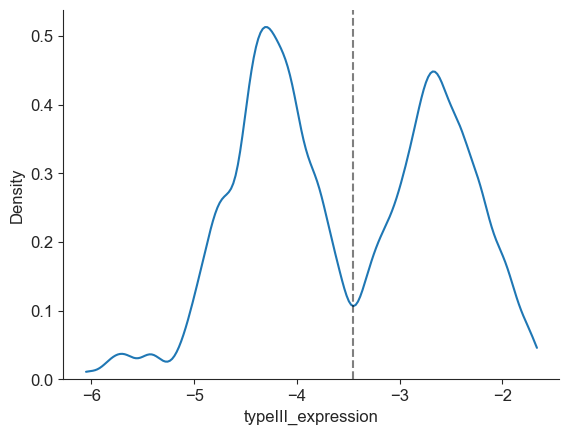

In [8]:
sns.kdeplot(np.log10(data[data.typeIII_expression > 0].typeIII_expression), cut=0, bw_method=0.1)
sns.despine()
plt.axvline(x=np.log10(0.00035),color = 'k',ls = '--', alpha =0.5)
data['type_III_IFN_positive'] = data.typeIII_expression >= 0.00035
plt.savefig('Figures/typeIIIcutoff_1905NSmut.pdf', format='pdf', bbox_inches = "tight")


As in A549 cells, are type I and type III interferons correlated?

The null hypothesis is rejected at a pvalue of 3.127249992007468e-122


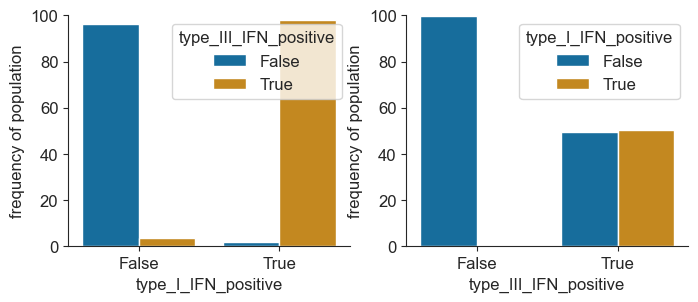

In [9]:
fig,axes = plt.subplots(1,2, figsize=(8,3))

contingency = pd.crosstab(data.type_I_IFN_positive, data.type_III_IFN_positive)
ratio, pval = scipy.stats.fisher_exact(contingency)
frequency = pd.crosstab(data.type_I_IFN_positive, data.type_III_IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'type_I_IFN_positive', y='value', hue='type_III_IFN_positive', palette = colors[:2],data=frequency, ax = axes[0])
sns.despine()
axes[0].set_ylabel('frequency of population')

axes[0].set_ylim(0,100)
frequency = pd.crosstab(data.type_III_IFN_positive, data.type_I_IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'type_III_IFN_positive', y='value', hue='type_I_IFN_positive', palette = colors[:2],data=frequency, ax = axes[1])
sns.despine()
axes[1].set_ylim(0,100)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')

plt.savefig('Figures/typeI_III_correlated_1905NSmut.pdf', format='pdf', bbox_inches = "tight")


In [10]:
data['IFN_positive'] = (data.type_I_IFN_positive) | (data.type_III_IFN_positive)

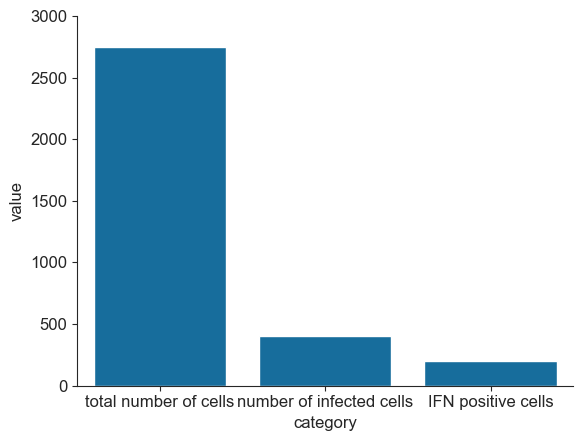

In [11]:
graph = pd.DataFrame({'category':['total number of cells', 'number of infected cells', 'IFN positive cells'], 
                      
                      
                      'value':[len(data), len(data[data.influenza_positive]), len(data[data.IFN_positive])]})
sns.barplot(data=graph, x='category', y='value', color=colors[0])
sns.despine()
plt.ylim(0,3000)
plt.savefig('Figures/summary_1905NSmut.pdf', format='pdf', bbox_inches = "tight")


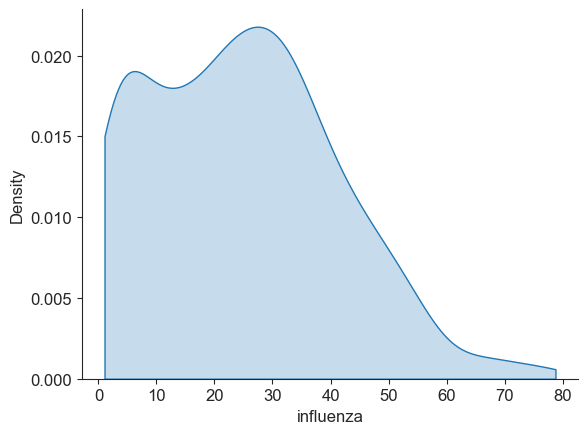

In [12]:
sns.kdeplot(data[data.influenza_positive].influenza * 100, cut=0, fill=True)
sns.despine()
plt.savefig('Figures/fluBurdenPosCells1905Mut.pdf', format='pdf', bbox_inches = "tight")

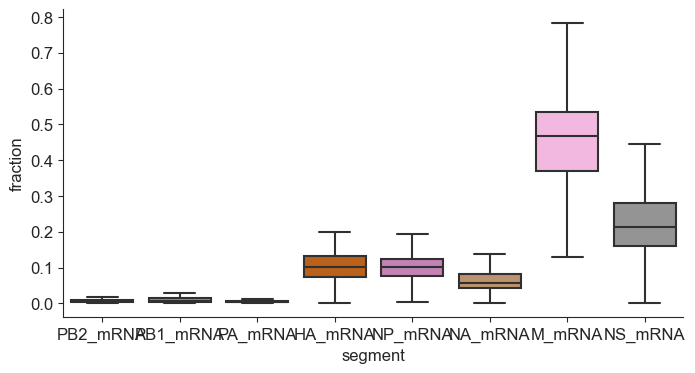

In [13]:
fig,ax = plt.subplots(1,1, figsize=(8,4))
 
graph = data[data.influenza_positive][segments].copy()
graph['sum'] = graph.sum(axis=1)
for segment in segments:
    graph[segment] = graph[segment]/graph['sum']
graph = graph[segments].stack().reset_index().rename(columns = {'level_1':'segment', 0:'fraction'})
sns.boxplot(data = graph, x= 'segment', y ='fraction', order = segments, palette = fluColors,  ax = ax, showfliers = False,)
sns.despine()
plt.savefig('Figures/frac1905mut.pdf', format='pdf', bbox_inches = "tight")

Is flu infection associated with interferon production?

The null hypothesis is rejected at a pvalue of 5.779723264170754e-122


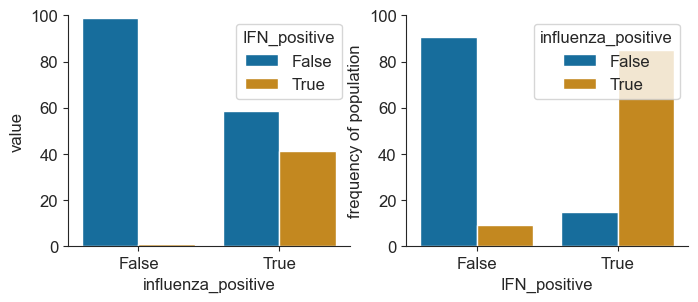

In [14]:
fig,axes = plt.subplots(1,2, figsize=(8,3))

contingency = pd.crosstab(data.influenza_positive, data.IFN_positive)
ratio, pval = scipy.stats.fisher_exact(contingency)
contingency = contingency.stack().reset_index().rename(columns={0:'value'})

frequency = pd.crosstab(data.influenza_positive, data.IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'influenza_positive', y='value', hue='IFN_positive', palette = colors[:2],data=frequency, ax = axes[0])
sns.despine()
axes[0].set_ylim(0,100)

frequency = pd.crosstab(data.IFN_positive, data.influenza_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'IFN_positive', y='value', hue='influenza_positive', palette = colors[:2],data=frequency, ax = axes[1])
sns.despine()
axes[1].set_ylim(0,100)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')
plt.savefig('Figures/fluIFN_1905NSmut.pdf', format='pdf', bbox_inches = "tight")


Is NS expression associated with interferon induction in high-flu cells?

/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/alistair/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The null hypothesis is rejected at a pvalue of 0.032576192199994095


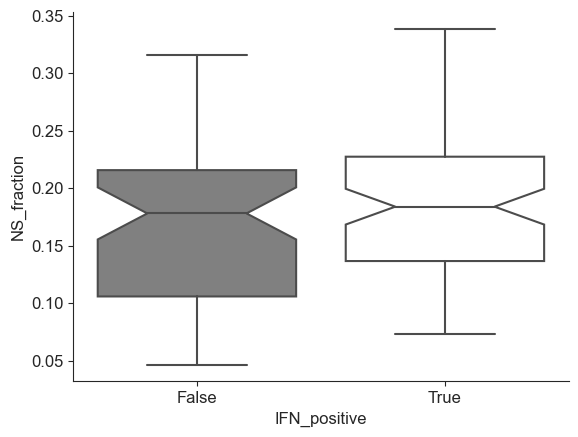

In [15]:
meanVal = data[(data.IFN_positive) & (data.influenza_positive)].influenza.median()

graph = data[data.influenza >= meanVal ]

graph['sum'] = graph[segments].sum(axis=1)
graph['NS_fraction'] = graph.NS_mRNA/graph['sum']
statistic, pval = scipy.stats.ttest_ind(graph[graph.IFN_positive].NS_fraction, graph[~(graph.IFN_positive)].NS_fraction, equal_var=False, alternative='greater')
sns.boxplot(x="IFN_positive", y="NS_fraction", data=graph, order=[False, True], notch=True, palette = ['0.5','1'], showfliers=False)
#plt.ylim(0,0.6)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of {0}'.format(str(pval)))
sns.despine()
plt.savefig('Figures/IFNvsNSfraction1905.pdf', format='pdf', bbox_inches = "tight")


The null hypothesis is rejected at a pvalue of 7.791517436682815e-07


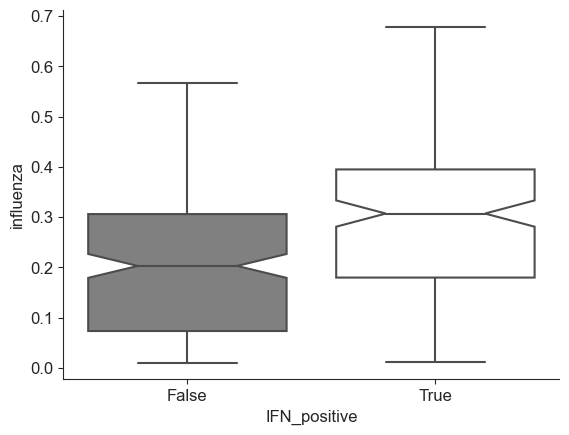

In [16]:
graph = data[data.influenza_positive]
statistic, pval = scipy.stats.ttest_ind(graph[graph.IFN_positive].influenza, graph[~(graph.IFN_positive)].influenza, equal_var=False, alternative='greater')
sns.boxplot(x="IFN_positive", y="influenza", data=graph, order=[False, True], notch=True, palette = ['0.5','1'], showfliers=False)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of {0}'.format(str(pval)))
sns.despine()
plt.savefig('Figures/IFNvsflufraction1905.pdf', format='pdf', bbox_inches = "tight")


assess deletions

In [17]:
#read in deletions, subset to accepted cells
deletions = pd.read_csv('Results/curatedDeletions_1905NSmut.tsv', sep='\t')[['barcode', 'segment', 'fiveprime', 'threeprime', 'count', 'nonDeletionCounts']]
deletions = deletions.rename(columns = {'barcode':'cell'})
deletions = deletions[deletions.cell.isin(data.cell)]
#filter to only > 200nt to exclude small deletions
deletions['length'] = deletions.threeprime-deletions.fiveprime
deletions = deletions[deletions.length > 200]
data['deletion_observed'] = data.cell.isin(deletions.cell)

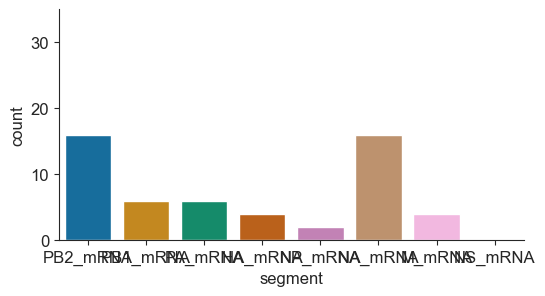

In [18]:
fig,ax = plt.subplots(figsize=(6,3))
graph = deletions.groupby(['segment']).count().reset_index()
sns.barplot(data=graph, x= 'segment', y='count', palette = otherfluColors, order= alternateFlu, ax =ax)
plt.ylim(0,35)
sns.despine()
a = ax.set_xticklabels(segments)
plt.savefig('Figures/deletions_1905NSmut.pdf', format='pdf', bbox_inches = "tight")


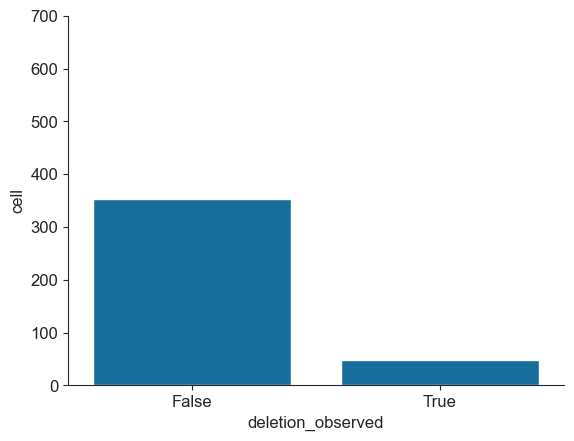

In [19]:
sns.barplot(data =data[data.influenza_positive].groupby(['deletion_observed']).count().reset_index(), x = 'deletion_observed', y='cell', color=colors[0])
sns.despine()
plt.ylim(0,700)
plt.savefig('Figures/numInfectionsDeletionsObserved_1905NSmut.pdf', format='pdf', bbox_inches = "tight")


Do they have an association with interferon?

The null hypothesis is rejected at a pvalue of 0.03435481544493145


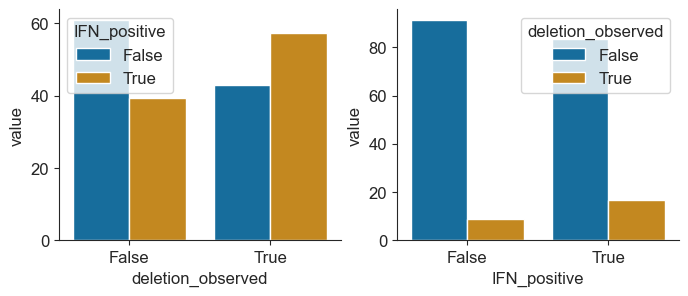

In [20]:
meanVal = data[(data.influenza_positive) & (data.deletion_observed)].influenza.median()

contingency = pd.crosstab(data[data.influenza >= meanVal].deletion_observed,data[data.influenza >= meanVal].IFN_positive)
ratio, pval = scipy.stats.fisher_exact(contingency)
fig,axes = plt.subplots(1,2, figsize=(8,3))

frequency = pd.crosstab(data[data.influenza_positive].deletion_observed, data[data.influenza_positive].IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'deletion_observed', y='value', hue='IFN_positive', palette = colors[:2],data=frequency, ax = axes[0])
sns.despine()

frequency = pd.crosstab(data[data.influenza_positive].IFN_positive, data[data.influenza_positive].deletion_observed, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'IFN_positive', y='value', hue='deletion_observed', palette = colors[:2],data=frequency, ax = axes[1])
sns.despine()

if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of {0}'.format(str(pval)))
plt.savefig('Figures/IFNdeletioncorrelation_1905NSmut.pdf', format='pdf', bbox_inches = "tight")


copy dataframe to NSmut, now assess WT for any differences.

In [21]:
NSframe = data.copy()
dataFolder = 'strainedCounts/1905WT/'

data = SingleCellPython.MatrixToPandaSoupX(dataFolder + 'barcodes.tsv', dataFolder + 'genes.tsv', dataFolder + 'matrix.mtx',
                                           False, False)



UMI threshold

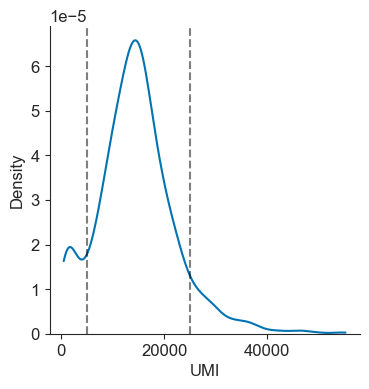

In [22]:
sums = data.groupby(['cell']).UMI.sum().reset_index()
figure, ax = plt.subplots(1,1, figsize=(4,4))
sns.kdeplot(sums.UMI, bw_method=0.2,  color=colors[0], ax=ax, cut=0)
sns.despine()
ax.axvline(x=5000,color = 'k',ls = '--', alpha =0.5)
ax.axvline(x=25000,color = 'k',ls = '--', alpha =0.5)
sums = sums.loc[(sums.UMI < 25000) & (sums.UMI > 5000)]
sums = sums.rename(columns = {'UMI':'total'})
data = data.merge(sums, on='cell')
plt.savefig('Figures/UMIcutoff_1905WT.pdf', format='pdf', bbox_inches = "tight")


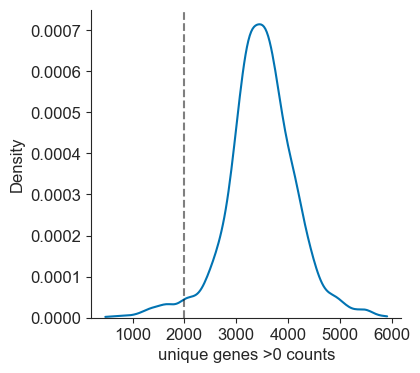

In [23]:
counts = data[data.UMI >0].groupby(['cell']).count().reset_index()
figure, ax = plt.subplots(1,1, figsize=(4,4))
sns.kdeplot(counts.UMI, bw_method=0.2,  color=colors[0], ax=ax, cut=0)
plt.xlabel('unique genes >0 counts')
sns.despine()
counts = counts.loc[(counts.UMI >= 2000)]['cell']
ax.axvline(x=2000,color = 'k',ls = '--', alpha =0.5)

data = data.merge(counts, on='cell')

plt.savefig('Figures/geneCountcutoff_1905NSWT.pdf', format='pdf', bbox_inches = "tight")

In [24]:
data['expression'] = data.UMI/data.total

genesOfInterest = segments + typeI + typeIII


typeIFrame = data[data.gene.isin(typeI)].groupby(['cell']).sum().reset_index()[['cell','expression']].rename(columns = {'expression':'typeI_expression'})

typeIIIFrame = data[data.gene.isin(typeIII)].groupby(['cell']).sum().reset_index()[['cell','expression']].rename(columns = {'expression':'typeIII_expression'})

fluFrame = data[data.gene.isin(segments)].groupby(['cell']).sum().reset_index()[['cell','expression']].rename(columns = {'expression':'influenza'})

data = data.loc[data.gene.isin(genesOfInterest),].pivot(index = 'cell', columns = 'gene', values = 'expression').fillna(0).reset_index()

data = data.merge(typeIFrame, on='cell', how='left').fillna(0)
data = data.merge(typeIIIFrame, on='cell', how='left').fillna(0)
data = data.merge(fluFrame, on='cell', how='left').fillna(0)

distribution of flu+. 

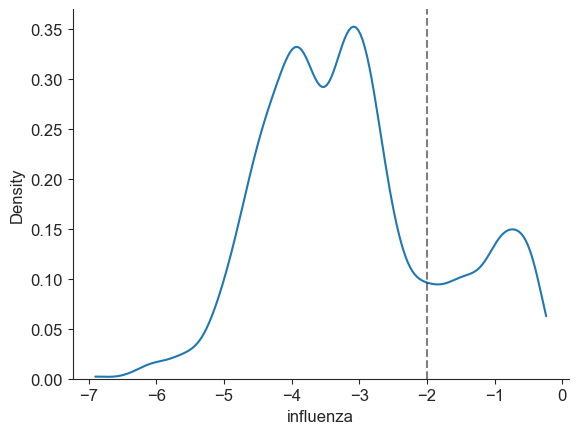

In [25]:
sns.kdeplot(np.log10(data[data.influenza > 0].influenza), cut=0, bw_method=0.15)
sns.despine()
data['influenza_positive'] = data.influenza >= 0.01
plt.axvline(x=np.log10(0.01),color = 'k',ls = '--', alpha =0.5)
plt.savefig('Figures/flucutoff_1905WT.pdf', format='pdf', bbox_inches = "tight")


And interferon

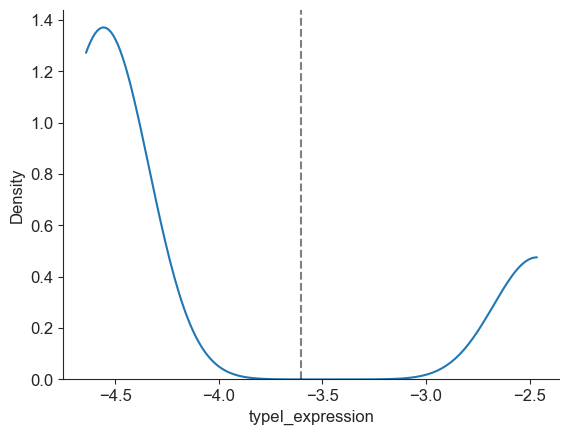

In [26]:
sns.kdeplot(np.log10(data[data.typeI_expression > 0].typeI_expression), cut=0, bw_method=0.2)
sns.despine()
plt.axvline(x=np.log10(0.00025),color = 'k',ls = '--', alpha =0.5)
data['type_I_IFN_positive'] = data.typeI_expression >= 0.00025
plt.savefig('Figures/typeIcutoff_1905WT.pdf', format='pdf', bbox_inches = "tight")


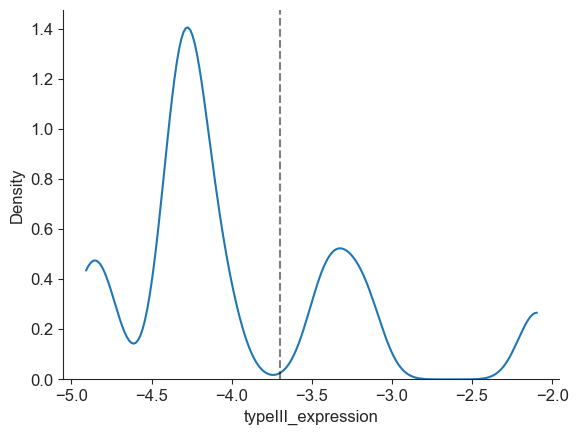

In [27]:
sns.kdeplot(np.log10(data[data.typeIII_expression > 0].typeIII_expression), cut=0, bw_method=0.15)
sns.despine()
plt.axvline(x=np.log10(0.0002),color = 'k',ls = '--', alpha =0.5)
data['type_III_IFN_positive'] = data.typeIII_expression >= 0.0002
plt.savefig('Figures/typeIIIcutoff_1905WT.pdf', format='pdf', bbox_inches = "tight")


The null hypothesis is rejected at a pvalue of 0.0015267175572448535


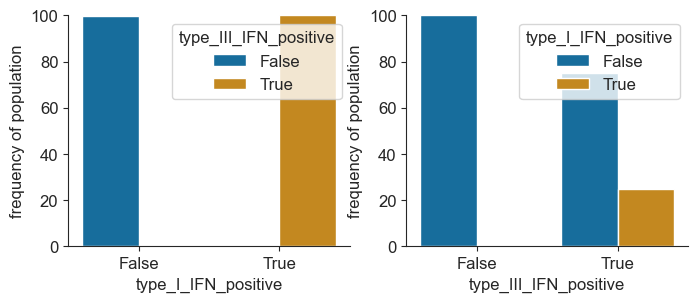

In [28]:
fig,axes = plt.subplots(1,2, figsize=(8,3))

contingency = pd.crosstab(data.type_I_IFN_positive, data.type_III_IFN_positive)
ratio, pval = scipy.stats.fisher_exact(contingency)
frequency = pd.crosstab(data.type_I_IFN_positive, data.type_III_IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'type_I_IFN_positive', y='value', hue='type_III_IFN_positive', palette = colors[:2],data=frequency, ax = axes[0])
sns.despine()
axes[0].set_ylabel('frequency of population')

axes[0].set_ylim(0,100)
frequency = pd.crosstab(data.type_III_IFN_positive, data.type_I_IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'type_III_IFN_positive', y='value', hue='type_I_IFN_positive', palette = colors[:2],data=frequency, ax = axes[1])
sns.despine()
axes[1].set_ylim(0,100)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')
plt.savefig('Figures/typeI_III_correlated_1905WT.pdf', format='pdf', bbox_inches = "tight")


In [29]:
data['IFN_positive'] = (data.type_I_IFN_positive) | (data.type_III_IFN_positive)

Summary (there are 5 interferon positive cells)

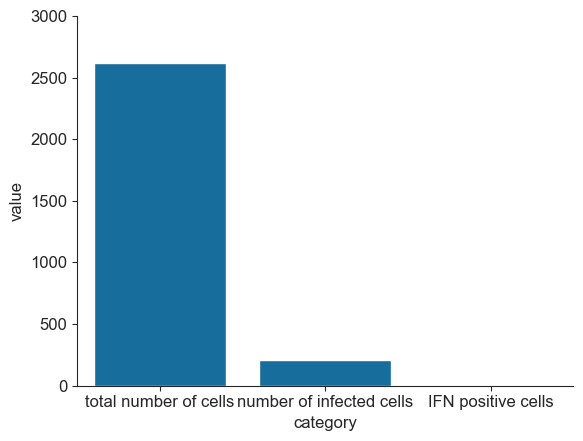

In [30]:
graph = pd.DataFrame({'category':['total number of cells', 'number of infected cells', 'IFN positive cells'], 
                      
                      
                      'value':[len(data), len(data[data.influenza_positive]), len(data[data.IFN_positive])]})
sns.barplot(data=graph, x='category', y='value', color=colors[0])
sns.despine()
plt.ylim(0,3000)
plt.savefig('Figures/summary_1905WT.pdf', format='pdf', bbox_inches = "tight")


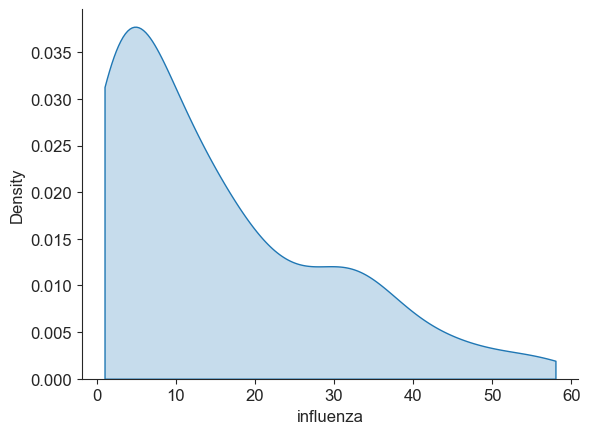

In [31]:
sns.kdeplot(data[data.influenza_positive].influenza * 100, cut=0, fill=True)
sns.despine()
plt.savefig('Figures/fluBurdenPosCells1905WT.pdf', format='pdf', bbox_inches = "tight")

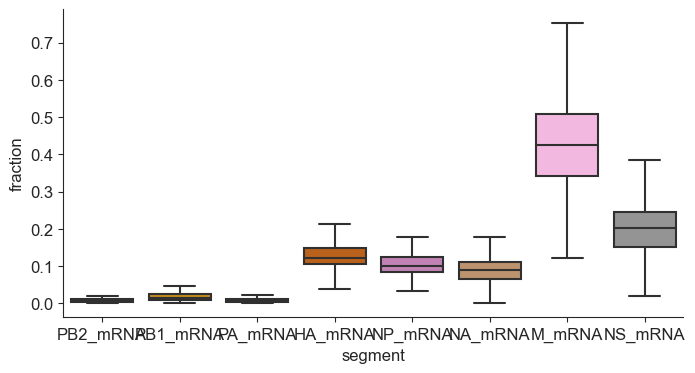

In [32]:
fig,ax = plt.subplots(1,1, figsize=(8,4))
 
graph = data[data.influenza_positive][segments].copy()
graph['sum'] = graph.sum(axis=1)
for segment in segments:
    graph[segment] = graph[segment]/graph['sum']
graph = graph[segments].stack().reset_index().rename(columns = {'level_1':'segment', 0:'fraction'})
sns.boxplot(data = graph, x= 'segment', y ='fraction', order = segments, palette = fluColors,  ax = ax, showfliers = False,)
sns.despine()
plt.savefig('Figures/frac1905WT.pdf', format='pdf', bbox_inches = "tight")

While rare, is interferon associated with flu infection?

The null hypothesis is rejected at a pvalue of 4.0973325751735206e-05


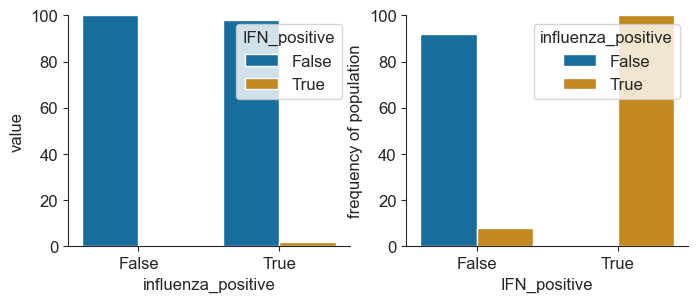

In [33]:
fig,axes = plt.subplots(1,2, figsize=(8,3))

contingency = pd.crosstab(data.influenza_positive, data.IFN_positive)
ratio, pval = scipy.stats.fisher_exact(contingency)
contingency = contingency.stack().reset_index().rename(columns={0:'value'})

frequency = pd.crosstab(data.influenza_positive, data.IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'influenza_positive', y='value', hue='IFN_positive', palette = colors[:2],data=frequency, ax = axes[0])
sns.despine()
axes[0].set_ylim(0,100)

frequency = pd.crosstab(data.IFN_positive, data.influenza_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'IFN_positive', y='value', hue='influenza_positive', palette = colors[:2],data=frequency, ax = axes[1])
sns.despine()
axes[1].set_ylim(0,100)
if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')

deletions

In [34]:
#read in deletions, subset to accepted cells
deletions = pd.read_csv('Results/curatedDeletions_1905WT.tsv', sep='\t')[['barcode', 'segment', 'fiveprime', 'threeprime', 'count', 'nonDeletionCounts']]
deletions = deletions.rename(columns = {'barcode':'cell'})
deletions = deletions[deletions.cell.isin(data.cell)]
#filter to only > 200nt to exclude small deletions
deletions['length'] = deletions.threeprime-deletions.fiveprime
deletions = deletions[deletions.length > 200]
data['deletion_observed'] = data.cell.isin(deletions.cell)

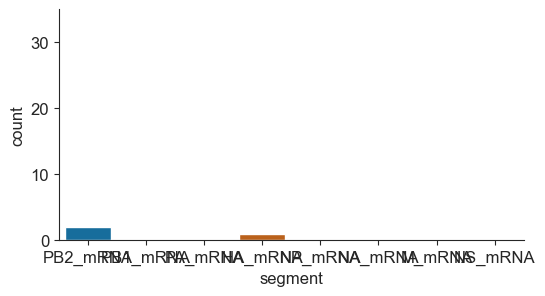

In [35]:
fig,ax = plt.subplots(figsize=(6,3))
graph = deletions.groupby(['segment']).count().reset_index()
sns.barplot(data=graph, x= 'segment', y='count', palette = otherfluColors, order= alternateFlu, ax =ax)
plt.ylim(0,35)
sns.despine()
a = ax.set_xticklabels(segments)
plt.savefig('Figures/deletions_1905WT.pdf', format='pdf', bbox_inches = "tight")


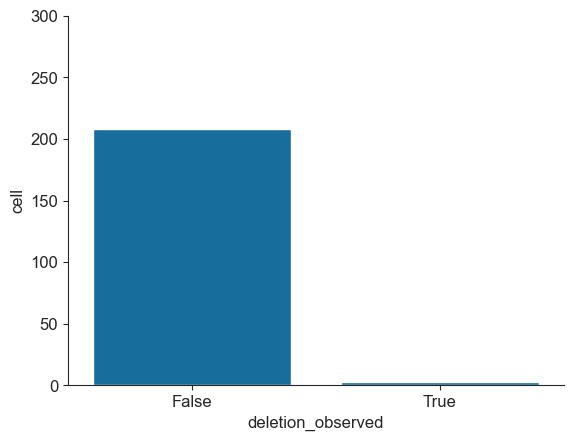

In [36]:
sns.barplot(data =data[data.influenza_positive].groupby(['deletion_observed']).count().reset_index(), x = 'deletion_observed', y='cell', color=colors[0])
sns.despine()
plt.ylim(0,300)
plt.savefig('Figures/numInfectionsDeletionsObserved_1905WT.pdf', format='pdf', bbox_inches = "tight")


the null hypothesis fails to be rejected at a pvalue of 1.0


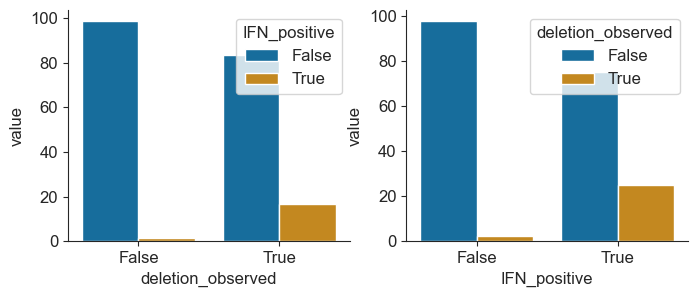

In [180]:
contingency = pd.crosstab(data[data.influenza >= meanVal].deletion_observed,data[data.influenza >= meanVal].IFN_positive)
ratio, pval = scipy.stats.fisher_exact(contingency)
fig,axes = plt.subplots(1,2, figsize=(8,3))

frequency = pd.crosstab(data[data.influenza_positive].deletion_observed, data[data.influenza_positive].IFN_positive, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'deletion_observed', y='value', hue='IFN_positive', palette = colors[:2],data=frequency, ax = axes[0])
sns.despine()

frequency = pd.crosstab(data[data.influenza_positive].IFN_positive, data[data.influenza_positive].deletion_observed, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'IFN_positive', y='value', hue='deletion_observed', palette = colors[:2],data=frequency, ax = axes[1])
sns.despine()

if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of {0}'.format(str(pval)))
plt.savefig('Figures/IFNdeletioncorrelation_1905WT.pdf', format='pdf', bbox_inches = "tight")